In [1]:
import theano.tensor as T
import theano
import numpy as np
import time

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from theano.printing import pp

In [3]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W = None, b = None, activation = T.tanh):
        """
        HIdden layer of MAP
        
        rng: for random state --> np.random.RandomState
        """
        self.input = input
        if W is None:
            W_values = np.asarray(
                rng.uniform(
                    low = - np.sqrt(6. / (n_in + n_out)),
                    high = np.sqrt(6. / (n_in + n_out)),
                    size = (n_in, n_out)
                    ),
                dtype = theano.config.floatX
                )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4.
            
            W1 = theano.shared(W_values, name='W1', borrow = True)
        
        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b1 = theano.shared(value=b_values, name='b1', borrow=True)
            
        self.W = W1
        self.b = b1
            
        lin_output = T.dot(input,self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
            )
            
        self.params = [self.W, self.b]
                    

In [4]:
class OutputLayer(object):
    def __init__(self, rng, input, n_in, n_out, W = None, b = None, activation = None):
        """
        Output layer of MAP
        
        rng: for random state --> np.random.RandomState
        """
        self.input = input
        
        if W is None:
            W_values = np.asarray(
                rng.uniform(
                    low = - np.sqrt(6. / (n_in + n_out)),
                    high = np.sqrt(6. / (n_in + n_out)),
                    size = (n_in, n_out)
                    ),
                dtype = theano.config.floatX
                )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4
            
            W2 = theano.shared(W_values, name='W2', borrow = True)
            
        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b2 = theano.shared(value=b_values, name='b2', borrow=True)
            
        self.W = W2
        self.b = b2
            
        lin_output = T.dot(input,self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
            )
            
        self.params = [self.W, self.b]

In [5]:
class MAP(object):
    
    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """ Initialization
        """
        self.hiddenLayer = HiddenLayer(
            rng = rng,
            input = input,
            n_in = n_in,
            n_out = n_hidden,
            activation = T.tanh
            )
        
        self.outputLayer = OutputLayer(
            rng = rng,
            input = self.hiddenLayer.output,
            n_in = n_hidden,
            n_out = n_out
            )
        
        self.params = self.hiddenLayer.params + self.outputLayer.params
        
    def L2_regulation(self,y):
        """ Returns the L2 regulation of object vector and predicted vetor
        """
        
        return T.sum((y - self.outputLayer.output) ** 2)

In [6]:
class MAPPING(object):
    """ Returns the mapping function 
    X: np.array --> n_samples x n_features
    Y: np.array --> n_samples x n_features
    lam: penalization for weights
    beta: weight for sparsity penalization
    sparsity_param: desired average activation of the hidden units
    """
    def __init__(self,learning_rate = 0.01, n_epochs = 1000, batch_size = 20, 
                 n_hidden = 200, lam = 1e-4, beta = 5, sparsity_param = 0.05):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.lam = lam
        self.beta = beta
        self.sparsity_param = sparsity_param
        self.W1  = None
        self.W2 = None
        self.b1 = None
        self.b2 = None
        self.x_mean = None
        self.x_std = None
        self.y_mean = None
        self.y_std = None
    
    def fit(self,X,Y):
        self.x_mean = X.mean()
        self.x_std = X.std()
        self.y_mean = Y.mean()
        self.y_std = Y.std()
        X = (X - self.x_mean) / self.x_std
        Y = (Y - self.y_mean) / self.y_std
        n_batches = X.shape[0] / self.batch_size

        shared_X = theano.shared(np.asarray(X, dtype = theano.config.floatX))
        shared_Y = theano.shared(np.asarray(Y, dtype = theano.config.floatX))

        ### Build model ###
        print "... building the model..."

        # allocate symbolic variables for the data
        index = T.lscalar() # index for a mini batch
        x = T.dmatrix('x')
        y = T.dmatrix('y')

        rng = np.random.RandomState(1234)

        # construct MAP class
        f_mapping = MAP(
            rng = rng,
            input = x,
            n_in = X.shape[1],
            n_hidden = self.n_hidden,
            n_out = Y.shape[1]
            )

        ### Cost function ########################################################
        hidden_output = f_mapping.hiddenLayer.output
        rho_hat = (T.sum(hidden_output, axis = 0) / X.shape[0] + 1) / 2 ## rescale to [0,1]
        L2 = f_mapping.L2_regulation(y)/ self.batch_size * 0.5 # penalization for vector
        reg = 0.5 * self.lam * (T.sum(f_mapping.hiddenLayer.W ** 2) + T.sum(f_mapping.hiddenLayer.b **2) + T.sum(f_mapping.outputLayer.W ** 2) + T.sum(f_mapping.outputLayer.b ** 2))
        sparsity = self.beta * T.sum(self.sparsity_param * T.log(self.sparsity_param / rho_hat) + (1 - self.sparsity_param) * T.log((1 - self.sparsity_param) / ( 1 - rho_hat)))
        cost = L2 + sparsity + reg 

        # compute the gradient of the cost wrt to parameters
        gparams = [T.grad(cost,param) for param in f_mapping.params]

        # specify how to update parameters
        updates = [
            (param, param - self.learning_rate * gparam)
            for param, gparam in zip(f_mapping.params, gparams)
            ]



        ## train the model
        train_model = theano.function(
            inputs = [index],
            outputs = cost,
            updates = updates,
            givens={
                x: shared_X[index * self.batch_size: (index + 1) * self.batch_size],
                y: shared_Y[index * self.batch_size: (index + 1) * self.batch_size]
                }
            )


        start_time = time.clock()

        epoch = 0
        done_looping = False

        while (epoch < self.n_epochs) and (not done_looping):
            epoch += 1
            minibatch_avg_cost = 0
            n = 0
            for minibatch_index in xrange(n_batches):
                minibatch_avg_cost += train_model(minibatch_index)
                n += 1
            print 'epoch', epoch
            print minibatch_avg_cost * 1. / n
        
        self.W1 = f_mapping.hiddenLayer.W.get_value()
        #print self.W1
        #print "-------------------------------------"
        #print
        self.b1 = f_mapping.hiddenLayer.b.get_value()
        self.W2 = f_mapping.outputLayer.W.get_value()
        self.b2 = f_mapping.outputLayer.b.get_value()
    
    def transfrom(self,X):
        """
        X: n_sample x n_features
        """
        X = (X - self.x_mean)/self.x_std
        Y = np.dot(np.tanh(np.dot(X,self.W1) + self.b1 ), self.W2 ) + self.b2
        return Y * self.y_std + self.y_mean

In [7]:
import os
f_dir = "/home/ce/workspace/data-fusion/"
os.chdir(f_dir)
import cPickle

OSError: [Errno 2] No such file or directory: '/home/ce/workspace/data-fusion/'

In [10]:
!ls -lh data/cifar-10-batches-py/

total 3.1G
-rw-r--r-- 1 ce ce  158 Mar 31  2009 batches.meta
-rw-r--r-- 1 ce ce  30M Mar 31  2009 data_batch_1
-rw-r--r-- 1 ce ce  30M Mar 31  2009 data_batch_2
-rw-r--r-- 1 ce ce  30M Mar 31  2009 data_batch_3
-rw-r--r-- 1 ce ce  30M Mar 31  2009 data_batch_4
-rw-r--r-- 1 ce ce  30M Mar 31  2009 data_batch_5
-rw-rw-r-- 1 ce ce  12K Mar 17 17:12 labels_vectors
-rw-r--r-- 1 ce ce   88 Jun  5  2009 readme.html
-rw-r--r-- 1 ce ce  30M Mar 31  2009 test_batch
-rw-rw-r-- 1 ce ce 285M Mar 17 17:12 test_x
-rw-rw-r-- 1 ce ce 6.6M Mar 17 17:12 test_y
-rw-rw-r-- 1 ce ce 2.5G Mar 17 17:12 train_x
-rw-rw-r-- 1 ce ce  59M Mar 17 17:12 train_y


In [11]:

with open("data/cifar-10-batches-py/test_x","r") as f:
    %time test_x = cPickle.load(f)
with open("data/cifar-10-batches-py/test_y","r") as f:
    %time test_y = cPickle.load(f)
with open("data/cifar-10-batches-py/train_x","r") as f:
    %time train_x = cPickle.load(f)
with open("data/cifar-10-batches-py/train_y","r") as f:
    %time train_y = cPickle.load(f)

CPU times: user 19.7 s, sys: 402 ms, total: 20.1 s
Wall time: 20.1 s
CPU times: user 474 ms, sys: 11.2 ms, total: 485 ms
Wall time: 485 ms
CPU times: user 2min 41s, sys: 2.97 s, total: 2min 44s
Wall time: 2min 44s
CPU times: user 3.71 s, sys: 59.4 ms, total: 3.77 s
Wall time: 3.78 s


In [12]:
mapping = MAPPING(n_hidden = 200, n_epochs = 200, batch_size = 200)
%time mapping.fit(train_x,train_y)

... building the model...
CPU times: user 50min 47s, sys: 3min 18s, total: 54min 5s
Wall time: 27min 10s


In [61]:
mapping = MAPPING(n_hidden = 200, n_epochs = 200, batch_size = 200)
%time mapping.fit(train_x,train_y)

... building the model...
epoch 1
1835.36973492
epoch 2
118917.534531
epoch 3
13541047.8011
epoch 4
1813703923.51
epoch 5
873342574018.0


KeyboardInterrupt: 

In [27]:
y_pred = mapping.transfrom(test_x)

In [29]:
train_y_pred = mapping.transfrom(train_x)

In [30]:
with open("data/cifar-10-batches-py/labels_vectors","r") as f:
    %time label_vec = cPickle.load(f)

CPU times: user 1.03 ms, sys: 147 µs, total: 1.17 ms
Wall time: 1.03 ms


In [31]:
sim_cosine_train = np.zeros((train_y_pred.shape[0],label_vec.shape[0]))
for i in xrange(train_y_pred.shape[0]):
    for j in xrange(label_vec.shape[0]):
        sim_cosine_train[i,j] = np.dot(train_y_pred[i],label_vec[j])/np.sqrt((train_y_pred[i]**2).sum())/np.sqrt((label_vec[j]**2).sum())

In [32]:
sim_cosine = np.zeros((y_pred.shape[0],label_vec.shape[0]))
for i in xrange(y_pred.shape[0]):
    for j in xrange(label_vec.shape[0]):
        sim_cosine[i,j] = np.dot(y_pred[i],label_vec[j])/np.sqrt((y_pred[i]**2).sum())/np.sqrt((label_vec[j]**2).sum())

In [33]:
train_pred = np.argsort(sim_cosine)[:,-1]

# Evaluation

In [34]:
## number of predict classes
from collections import Counter
print Counter(np.argsort(sim_cosine)[:,-1])

Counter({3: 3586, 2: 1581, 7: 383, 4: 233, 6: 92, 0: 81, 8: 26, 1: 10, 9: 8})


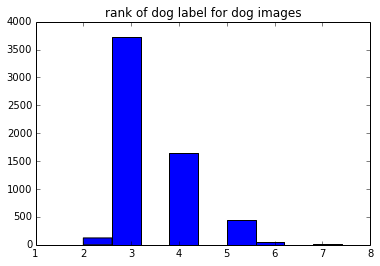

In [35]:
import matplotlib.pylab as pl
%matplotlib inline
rank = 10 - np.where(np.argsort(sim_cosine) == 5)[1]
pl.hist(rank,bins=10)
pl.title('rank of dog label for dog images')

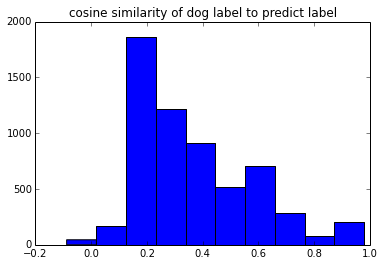

In [36]:
import matplotlib.pylab as pl
%matplotlib inline
pl.hist(sim_cosine[np.where(np.argsort(sim_cosine) == 5)])
pl.title('cosine similarity of dog label to predict label')

In [37]:
cosine_dog = np.zeros((train_x.shape[0] + test_x.shape[0],))
tmp = np.concatenate((train_y_pred, y_pred))
for i in xrange(cosine_dog.shape[0]):
    cosine_dog[i] = np.dot(label_vec[5],tmp[i])/np.sqrt((label_vec[5]**2).sum())/np.sqrt((tmp[i]**2).sum())

In [39]:
with open("data/cifar-10-batches-py/batches.meta","r") as f:
    meta = cPickle.load(f)

In [40]:
j = 0
info = []
for i in meta["label_names"]:
    print j, i
    info.append((j,i))
    j+= 1

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [42]:
labels = np.zeros((train_y.shape[0],))
for i in xrange(train_y.shape[0]):
    for j in xrange(label_vec.shape[0]):
        if (label_vec[j] == train_y[i]).all():
            labels[i] = j
            pass

In [43]:
for i in np.argsort(cosine_dog)[::-1][:200]:
    if i > train_x.shape[0] - 1:
        print 'dog'
    else:
        j = int(labels[i])
        print info[j][1]

dog
cat
cat
dog
dog
dog
cat
cat
cat
cat
dog
dog
cat
deer
dog
dog
dog
dog
cat
cat
cat
dog
cat
horse
cat
cat
horse
dog
cat
deer
truck
dog
dog
horse
cat
cat
dog
dog
cat
automobile
cat
dog
cat
cat
horse
cat
cat
dog
cat
cat
cat
cat
deer
dog
dog
dog
cat
dog
dog
dog
cat
cat
dog
cat
cat
cat
cat
cat
cat
dog
dog
dog
cat
dog
cat
deer
dog
deer
dog
cat
dog
cat
dog
cat
dog
dog
dog
cat
dog
cat
dog
cat
dog
cat
cat
bird
dog
bird
dog
horse
cat
dog
cat
dog
dog
dog
dog
dog
cat
dog
dog
dog
dog
cat
dog
horse
cat
bird
cat
dog
horse
dog
bird
cat
dog
cat
horse
dog
dog
dog
cat
dog
dog
dog
cat
dog
cat
dog
cat
cat
cat
cat
bird
cat
dog
cat
dog
cat
dog
dog
horse
dog
horse
deer
dog
cat
cat
dog
dog
cat
dog
dog
dog
dog
dog
horse
cat
cat
dog
dog
dog
cat
cat
cat
dog
cat
dog
cat
cat
dog
cat
deer
dog
dog
dog
cat
horse
dog
cat
horse
horse
deer
dog
cat
cat
cat
cat
cat
dog
cat


In [ ]:
print train_y_pred

In [44]:
sim_cosine = np.zeros((train_y_pred.shape[0],label_vec.shape[0]))
for i in xrange(train_y_pred.shape[0]):
    for j in xrange(label_vec.shape[0]):
        sim_cosine[i,j] = np.dot(train_y_pred[i],label_vec[j])/np.sqrt((train_y_pred[i]**2).sum())/np.sqrt((label_vec[j]**2).sum())

In [45]:
from collections import Counter
print np.argsort(sim_cosine)[:,-1]

[6 9 0 ..., 3 2 7]


In [46]:
Counter(np.array(np.argsort(sim_cosine)[:,-1]) == labels)

Counter({True: 41534, False: 12466})